# Signal processing hackathon

Applying machine learning techniques to audio signals

In [1]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [2]:
# import numpy and matplotlib
%pylab inline
rcParams['figure.figsize'] = 20, 5

Populating the interactive namespace from numpy and matplotlib


In [3]:
# standard audio sample rate (samples per second)
sample_rate = 44100.

## Metadata

In [4]:
from metadata import *

In [32]:
# metadata about the people from which recordings are available
# we can use this for different labelings of the data
people

{'Andrew': {'age': 40, 'gender': 'male', 'nationality': 'Australian'},
 'Gabriele': {'age': 32, 'gender': 'male', 'nationality': 'Italian'},
 'Ivo': {'age': 35, 'gender': 'male', 'nationality': 'Dutch'},
 'Jelte': {'age': 24, 'gender': 'male', 'nationality': 'Dutch'},
 'Marcel': {'age': 33, 'gender': 'male', 'nationality': 'Dutch'},
 'Nelli': {'age': 35, 'gender': 'female', 'nationality': 'Russian'},
 'Ron': {'age': 32, 'gender': 'male', 'nationality': 'Dutch'}}

In [33]:
# the sentences that have been recorded
sentences

{'s1': 'I want to implement a speech recognition system',
 's2': 'the fourier transform is super cool but rather complex'}

## Read data

In [34]:
# point to folder where data is stored
data_folder = 'speech_samples/'

In [35]:
# convert all m4a files in folder to wav with ffmpeg
# this is of course not necessary if you already have wav files
import os
def m4a2wav(data_folder):
    m4a_list = [os.path.join(data_folder, file_name)
                for file_name in os.listdir(data_folder)
                if file_name.endswith('m4a')]
    for m4a_file in m4a_list:
        print(m4a_file)
        os.system('ffmpeg -y -i {} {}'.format(m4a_file, m4a_file[:-3]+'wav'))

# convert all m4a files
for person in people.keys():
    m4a2wav(os.path.join(data_folder, person))

In [36]:
# play a wav file
from IPython.display import *
def play_sound(data):
    global sample_rate
    if type(data) == str:
        return Audio(filename=data, autoplay=True, rate=sample_rate)
    else:
        return Audio(data.astype(int16), autoplay=True, rate=sample_rate)
    
play_sound(os.path.join(data_folder, 'Ivo', 's1.wav'))

In [43]:
# play a wave
play_sound((random.rand(100000)*10-5).astype(int16))

### Build a synthesizer - because we can

With the Fourier transform you can decompose a signal into harmonics - and you could sum harmonics to create electronic music.

In [49]:
# so we can create electronic music!
def sinusoid(t, a, f, o=0):
    return a*sin(f*2*pi*t+o)

def create_sound(num_harmonics, bpm=80, duration=5, noise_easing=True):
    global sample_rate
    wave = zeros(duration*sample_rate)
    t = arange(len(wave))
    # add harmonics
    for i in range(num_harmonics):
        amp = 300 + random.rand() * 300
        frq = .01 + random.rand() * .01
        off = random.rand() * 5
        har = sinusoid(t, amp, frq, off)
        # add noise
        if noise_easing:
            har += 100 * t * random.rand(len(wave)) / max(t)
        wave += har
    # add beat
    beat_duration = int(sample_rate / (2 + random.rand() * 6))
    beat_amp = 2000 + random.rand() * 300
    beat_frq = .00001 + random.rand() * .0001
    beat_pos = int(sample_rate / (bpm / 60.))
    for bp in arange(beat_pos/2, len(wave), beat_pos):
        idx = arange(bp-beat_duration/2, bp+beat_duration/2).astype(int)
        wave[idx] += sinusoid(arange(len(idx)), beat_amp, beat_frq)
    return wave.astype(int16)

In [50]:
play_sound(create_sound(1, bpm=1, duration=5, noise_easing=False))

## Load the speech data

In [51]:
# read a wav file
from scipy.io import wavfile
def read_wave(filepath):
    # sample rate is 44100
    sample_rate, audio_channels = wavfile.read(filepath)
    # return mono signal - there is no difference between left and right
    # and normalize to have 1/-1 as most loud/quite
    return audio_channels[:,0] / float(np.max(np.abs(audio_channels[:,0])))
    
s1 = read_wave(os.path.join(data_folder, 'Nelli', 's1.wav'));
s2 = read_wave(os.path.join(data_folder, 'Gabriele', 's1.wav'));

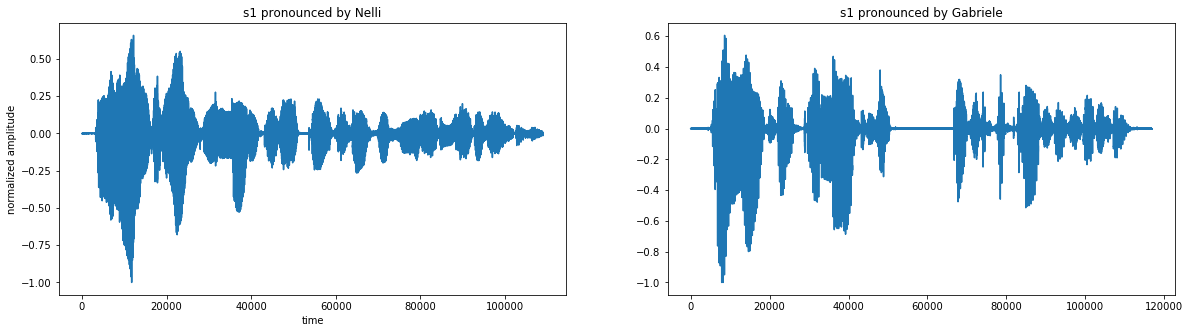

In [52]:
# plot Nelli's first sentence
subplot(121); plot(s1); title('s1 pronounced by Nelli');
xlabel('time'); ylabel('normalized amplitude');
# plot Gabriele's first sentence
subplot(122); plot(s2); title('s1 pronounced by Gabriele');

## Extract features based on FFT

In [53]:
# extract features from a wave with fft (which is just available due to the pylab namespace)
# return the power spectrum along with the frequency bins over which it is defined
def fourier_transform(w):
    global sample_rate
    freq_bins = fft.rfftfreq(len(w), 1/sample_rate)
    power = absolute(fft.rfft(w))**2 / len(w)
    return power, freq_bins

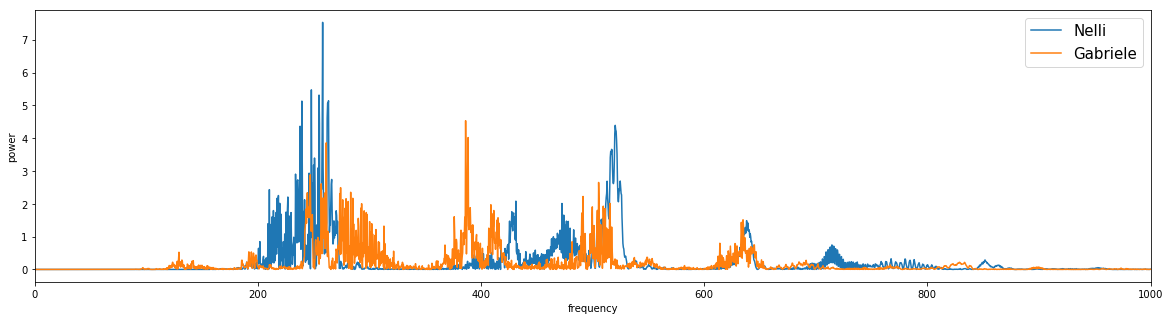

In [54]:
p1, f1 = fourier_transform(s1);
p2, f2 = fourier_transform(s2);
plot(f1, p1, label='Nelli');
plot(f2, p2, label='Gabriele');
pyplot.xlim([0, 1000]); pyplot.legend(fontsize=15);
xlabel('frequency'); ylabel('power');

In [56]:
# feature extraction v1:
# extract the amount of power in a given frequency range
def power_at(power, freq, lbound, hbound):
    lbin = argmin(abs(freq - lbound))
    hbin = argmin(abs(freq - hbound))
    # TODO: correct for exact localization of the l and h frequencies
    return sum(power[lbin:hbin])

# feature extraction v2:
# Use the integral representation instead => should be faster
# For the importance of integral images for computer vision, see e.g.
# https://en.wikipedia.org/wiki/Viola–Jones_object_detection_framework
def power_integral_at(pow_int, freq, lbound, hbound):
    lbin = argmin(abs(freq - lbound))
    hbin = argmin(abs(freq - hbound))
    return pow_int[hbin]-pow_int[lbin]

# short-hand
integral = lambda p, f, lb, hb: power_integral_at(p, f, lb, hb)
regular = lambda p, f, lb, hb: power_at(p, f, lb, hb)

# show the similarity! (and slight difference, do you know why?)
p1_int = cumsum(p1)
p2_int = cumsum(p2)
print('regular sum:\t', round(regular(p1, f1, 200, 300),1), round(regular(p2, f2, 200, 300),1))
print('cumulative sum:\t', round(integral(p1_int, f1, 200, 300),1), round(integral(p2_int, f2, 200, 300),1))

regular sum:	 234.3 143.1
cumulative sum:	 234.2 143.4


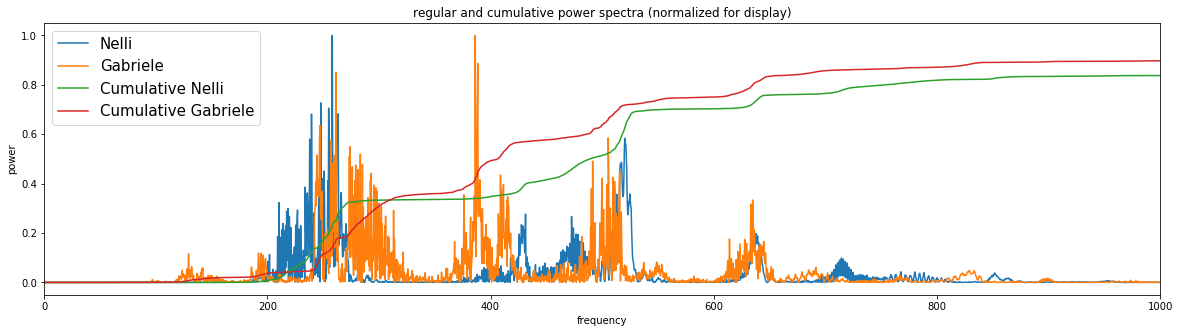

In [57]:
plot(f1, p1/max(p1), label='Nelli');
plot(f2, p2/max(p2), label='Gabriele');
plot(f1, p1_int/max(p1_int), label='Cumulative Nelli');
plot(f2, p2_int/max(p2_int), label='Cumulative Gabriele');
pyplot.xlim([0, 1000]); pyplot.legend(fontsize=15);
xlabel('frequency'); ylabel('power');
title('regular and cumulative power spectra (normalized for display)');

In [58]:
%timeit regular(p1, f1, 200, 50000)

The slowest run took 4.97 times longer than the fastest. This could mean that an intermediate result is being cached.
1000 loops, best of 3: 237 µs per loop


In [59]:
%timeit integral(p1_int, f1, 200, 50000)

1000 loops, best of 3: 197 µs per loop


Computations based on the integral representation is faster.

## Create dataset

In [60]:
# dataset params: consider frequencies up to freq_max and chop up the signal in steps of freq_step
freq_step = 100
freq_max = 1000
lbounds = arange(0, freq_max, freq_step)
lbounds

array([  0, 100, 200, 300, 400, 500, 600, 700, 800, 900])

In [61]:
# compute features and labels
features = []
labels = []
# keep waves in memory for later usage
waves = []
for person in people.keys():
    for s in sentences.keys():
        w = read_wave(os.path.join(data_folder, person, '{}.wav'.format(s)));
        p, f = fourier_transform(w)
        p_int = cumsum(p)
        features.append(array([power_integral_at(p_int, f, b, b+freq_step) 
                               for b in lbounds]))
        labels.append([person,
                       people[person]['nationality'],
                       people[person]['gender'],
                       people[person]['age'],
                       s])
        waves.append(w)

In [62]:
# create dataframe
feature_columns = ['f{}'.format(i) for i in range(len(features[0]))]
label_columns = ['name', 'nationality', 'gender', 'age', 'sentence']
dataset = pd.DataFrame(data=concatenate((features, labels), axis=1),
                       columns=concatenate((feature_columns, label_columns)))

# normalize the features
from sklearn import preprocessing
dataset[feature_columns] = preprocessing.StandardScaler().fit_transform(dataset[feature_columns])

# also include numeric labels
for label in label_columns:
    dataset['n_{}'.format(label)] = preprocessing.LabelEncoder().fit_transform(dataset[label])
    
dataset.head(10).T

,0,1,2,3,4,5,6,7,8,9
f0,-0.456394,-0.444911,-0.45035,-0.474792,-0.470349,-0.304348,-0.228779,-0.291622,-0.461469,-0.417408
f1,0.714746,-0.628962,-0.722013,-0.947461,0.673769,2.29346,-0.717452,-0.802382,-0.500525,-0.619444
f2,-0.0266515,-1.2499,2.08514,1.77516,-0.473773,-0.411067,-1.25626,-1.32686,-0.45943,0.4616
f3,2.46097,-0.65929,-0.602605,-1.21807,1.09927,-0.418548,-0.245848,-0.73513,1.15855,-0.276718
f4,2.4023,-0.833358,1.0384,-0.160524,-0.586527,-0.604074,-0.511729,-0.706575,1.54697,-0.508266
f5,-0.282712,-0.89742,2.72171,0.532932,0.377575,0.628763,-1.02759,-0.77865,-0.331976,-0.553022
f6,-0.555112,-0.272917,-0.655784,0.0672625,1.36996,0.143728,-1.2827,-0.972604,2.73118,0.557627
f7,0.0108283,-0.858824,-0.0860659,1.25615,2.20428,-0.35745,-0.852281,-0.741427,0.974104,-0.866845
f8,0.199667,0.882972,0.00309343,-0.0227094,1.23492,-0.211259,-0.877873,-1.24149,-0.598745,0.148962
f9,-0.000865049,-0.41234,0.668969,-0.717386,0.626829,-0.199214,-0.561108,-0.0385266,-0.246827,-0.77558


In [63]:
dataset.shape

(14, 20)

# Now solve a problem of your choice using awesome signal processing and/or machine learning methods